In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.linalg import solve
import os

In [2]:
def beta_matrix(w, d, t, e, m):
    dim = 2 * m

    w = w[:,None,None]

    base_val = (w + 1j*d)

    base = base_val * np.eye(2*m)[None,:,:]


    idy = np.arange(0,2*m-1,1)

    base[:,idy,idy+1] = t
    base[:,idy+1,idy] = t

    idx = np.arange(0,m,2)

    base[:,idx,2*m-1-idx] = t
    base[:,2*m-1-idx,idx] = t


    return base 

In [3]:
def T1_matrix(t, m):
    dim = 2 * m
    T = np.zeros((dim, dim), dtype=np.complex128)

    n = np.arange(1, (m - 1)//2 + 1)
    i = 2*n - 1           # to 0-based
    j = 2*m - 2*n

    T[i, j] = t
    return T


In [4]:

def leads_vectorized(w_vals, d, t, e, n, tol=1e-6, max_iter=200000):
    B = len(w_vals)
    unit_batch = beta_matrix(w_vals, d, t, e, n)
    
    # g = inv(unit) using solve (much faster than LU)
    eye_dim = np.eye(unit_batch.shape[-1])
    g = np.stack([solve(unit_batch[i], eye_dim) for i in range(B)])
    
    G = g.copy()
    hopp = T1_matrix(t, n)
    hoppT = hopp.T
    dim = g.shape[-1]
    iden = np.eye(dim)[None,:,:]

    diff = np.inf
    count = 0
    pbar = tqdm(total=max_iter, desc="Dyson iteration", leave=True)

    while diff > tol and count < max_iter:
        A = iden - g @ hoppT @ G @ hopp

        G_new = np.stack([solve(A[i], g[i]) for i in range(B)])

        diff = np.max(np.abs(G_new - G))
        G = G_new
        count += 1
        
        pbar.update(1)
        pbar.set_postfix({"diff": diff})

    pbar.close()
    return G, count


In [5]:
def compute(n):
    w_vals = np.arange(0, 3, 0.01)

    G_all, iterations = leads_vectorized(
        w_vals=w_vals,
        d=1e-3,
        t=1,
        e=0,
        n=n
    )


    return G_all, iterations

In [6]:
import os

In [ ]:
for l in range(5, 30):
    dir_path = os.path.expanduser(f'~/Desktop/backup/agnr/size_{l}')
    os.makedirs(dir_path, exist_ok=True)
    print(f"working on : ====> {l}" )
    G_all, iters = compute(l)

    fn = os.path.join(dir_path, f'leads_{l}.npy')
    np.save(fn, G_all)


In [7]:
def connection(t,m):
    idx = np.arange(2,m,2)
    base = np.zeros((2*m,2*m),dtype=np.complex64)

    base[2*m - idx,idx - 1] = t 

    return base

In [8]:
def unitcell(w, d, t, e, m):
    dim = 2 * m

    base_val = (w + 1j*d)

    base = base_val * np.eye(2*m)

    idy = np.arange(0,2*m-1,1)

    base[idy,idy+1] = t
    base[idy+1,idy] = t

    idx = np.arange(0,m,2)

    base[idx,2*m-1-idx] = t
    base[2*m-1-idx,idx] = t


    return base 

In [47]:
g_7 = compute(7)

np.save(os.path.expanduser(r"c:\Users\mukim\Downloads\transmissions\leads\agnr_7.npy"),g_7)

Dyson iteration:   2%|▏         | 3627/200000 [03:07<2:49:04, 19.36it/s, diff=9.98e-7] 


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [45]:
path = os.getcwd()
print(path)

c:\Users\mukim\Downloads\transmissions\notebooks


In [10]:


# ----------------------------------------------------------------------
# 1) Precomputed global cache of device_combs per width
# ----------------------------------------------------------------------
DEVICE_COMBS = {}


def _get_device_combs(width: int) -> np.ndarray:
    """
    Return (global cached) device combinations for a given width.
    Each row is (i, j) with i in [0..99] and j in [0..width-1].
    """
    width = int(2*width)
    if width not in DEVICE_COMBS:
        # Build once, store once
        DEVICE_COMBS[width] = np.stack(
            np.meshgrid(np.arange(100), np.arange(width), indexing="ij"),
            axis=-1
        ).reshape(-1, 2)
    return DEVICE_COMBS[width]


# ----------------------------------------------------------------------
# 2) Cached selection of N random impurity sites for a given config
# ----------------------------------------------------------------------
@lru_cache(maxsize=2048)
def chosen_for_config(n: int, width: int, config: int) -> np.ndarray:
    """
    Return n rows selected deterministically by given config.
    Completely cached.
    """
    n = int(n)
    width = int(width)
    config = int(config)

    device_combs = _get_device_combs(width)

    rng = np.random.RandomState(config)
    idx = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[idx]


# ----------------------------------------------------------------------
# 3) Factory: returns function(seed) → chosen impurity rows
# ----------------------------------------------------------------------
def possible_combs(n: int, width: int):
    n = int(n)
    width = int(width)

    def combs_for_seed(seed: int):
        return chosen_for_config(n, width, seed)

    return combs_for_seed


# ----------------------------------------------------------------------
# 4) Device builder
# ----------------------------------------------------------------------
def unidevice(w, d, t, e, size, config, n, numberofunitcell, combs_fn=None):
    """
    Build a device Hamiltonian unit with impurities inserted at positions
    determined by 'config'. Uses vectorised assignments where possible.
    """

    size = int(size)

    
    if combs_fn is None:
        combs_fn = possible_combs(int(n), int(size))

    # Chosen impurity coordinates
    imps = combs_fn(int(config))
    x = imps[:, 0]
    y = imps[:, 1]

    z = int(numberofunitcell)

    # Base Hamiltonian (already cached inside your unitcell_leads)
    mat = unitcell(w, d, t, e, int(size))

    # Identify impurities in unitcell z
    mask = (x == z)
    if not np.any(mask):
        return mat  # fast path return

    imp_indices = y[mask]

    # Vectorised diagonal modification
    diag_val = (w + 1j*d - 0.5)
    mat[imp_indices, imp_indices] = diag_val

    return mat


In [ ]:
g21 = np.load(os.path.expanduser(f'~/Desktop/backup/agnr/size_{21}/leads_{21}.npy'))
g21

In [40]:


def device_transmission(w, d, t, e,size,config,concentration):
    ene = int(w*100)
    m = 7    



    left = g_7[0][ene]     # left lead surface Green's function
    right = g_7[0][ene]     # right lead

    T  = connection(t,m)

    I = np.eye(2*m, dtype=complex)
    Td = T.conj().T
    

    tin =  T1_matrix(t, m)

    tin_d = tin.T


    combs_fn = possible_combs(concentration,size)

    g_new = left


    for i in range(100):
        
        unit = unidevice(w, d, t, e, size, config, concentration, i, combs_fn=combs_fn)
#        print(unit.shape)
        gd = np.linalg.inv(unit)

        G = np.linalg.solve(I - gd @ tin_d @ g_new @ tin, gd)

        g_new = G


    left_device = g_new

    IL = np.linalg.solve(I - left_device @ Td @ right @ Td, left_device)
    IR = np.linalg.solve(I - right @ Td @ left_device @ Td, right)
    gdd = IL - IL.conj().T
    grr = IR - IR.conj().T

    Gnonlocal = right @ Td @ IL
    GNON = Gnonlocal - Gnonlocal.conj().T

    term1 = gdd @ T @ grr @ Td
    term2 = T @ GNON @ Td @ GNON

    tr1 = np.abs(np.trace(term1 - term2))

    return tr1


In [43]:
device_transmission(0,1e-3,1,0,7,1,10)

np.float64(3.999989867790087)

(0.0, 3.2)

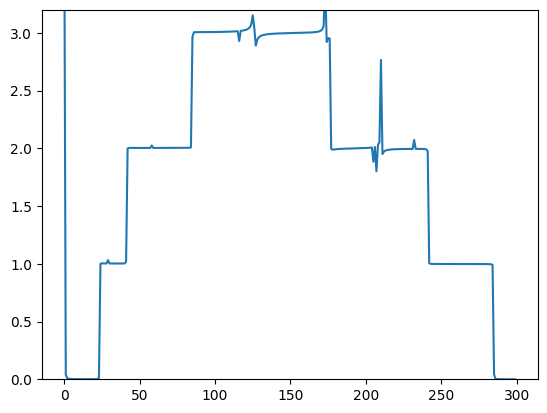

In [44]:
dos = [np.abs(device_transmission(w,1e-3,1,0,7,1,0)) for w in np.arange(0,3,0.01)]
plt.plot(dos)
plt.ylim(0,3.2)

In [ ]:
w = np.arange(0,3,0.01)
"""  device_transmission(w, d, t, e,size,config,concentration)"""


def transmission(config, conc):
    trans = [device_transmission(i, 0.0001, 1, 0,7,config,conc) for i in np.arange(0,3,0.01)]

    return trans


In [12]:
pris = [device_transmission(i, 0.0001, 1, 0,7,1,0) for i in np.arange(0,3,0.01)]

ValueError: operands could not be broadcast together with shapes (300,14,14) (14,14,300) 

In [14]:
import h5py
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count


def run_transmission(args):
    config, conc = args
    return transmission(config, conc)


def main():
    concs = np.arange(1, 50, 2)
    nc = len(concs)

    nconfigs = 10000
    nE = 300
    nF = 1

    outdir = os.path.expanduser('~/Desktop/backup/agnr/size_21')
    os.makedirs(outdir, exist_ok=True)
    h5_path = f"{outdir}/all_transmissions_mp.h5"

    NPROC = max(1, cpu_count() - 1)
    print(f"Using {NPROC} CPU cores…")

    with h5py.File(h5_path, "w") as f:

        dset = f.create_dataset(
            "transmissions",
            shape=(nc, nconfigs, nE, nF),
            dtype=np.float64,
            compression="gzip",
            compression_opts=4,
            chunks=(1, 500, nE, nF)
        )

        for i, conc in enumerate(tqdm(concs, desc="Concentration sweep")):

            args = [(cfg, conc) for cfg in range(nconfigs)]

            batch_list = []
            with Pool(NPROC) as p:
                for result in tqdm(
                    p.imap(run_transmission, args, chunksize=20),
                    total=nconfigs,
                    desc=f"configs conc={conc}",
                    leave=False,
                ):
                    batch_list.append(result)

            batch = np.asarray(batch_list).reshape(nconfigs, nE, nF)
            dset[i] = batch


if __name__ == "__main__":
    main()


Using 23 CPU cores…


Concentration sweep:   0%|          | 0/25 [00:00<?, ?it/s]Process ForkPoolWorker-44:
Process ForkPoolWorker-42:
Process ForkPoolWorker-36:
Process ForkPoolWorker-24:
Process ForkPoolWorker-31:
Process ForkPoolWorker-37:
Process ForkPoolWorker-33:
Process ForkPoolWorker-41:
Process ForkPoolWorker-27:
Process ForkPoolWorker-45:
Process ForkPoolWorker-32:
Traceback (most recent call last):
Process ForkPoolWorker-26:
  File "/home/shardul/miniconda3/envs/ml/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-38:
Process ForkPoolWorker-46:
Traceback (most recent call last):
  File "/home/shardul/miniconda3/envs/ml/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shard

KeyboardInterrupt: 